In [30]:
import os.path

from model import get_models_and_path, get_vggs_and_path, get_resnets_and_path
import torch
import pandas as pd
from plot_and_print import plot_tile
import os
from PIL import Image
import matplotlib.pyplot as plt
from zennit.attribution import Gradient
import zennit as zen
from relevance import plot_relevance
from data_loader import TileLoader
from scipy import stats
import torchvision

import numpy as np


In [53]:
data_dir = "../results/"
patients = [os.path.basename(f) for f in os.scandir(data_dir) if f.is_dir()]
patients.remove('p021')
filenames = []
for patient in patients:
    filenames.append(data_dir + patient + "/RUBCNL_results.csv")

df = pd.read_csv(filenames[0])
def cut_path(x):
    return x[3:]
new_col = df.path
new_col = new_col.apply(cut_path)
df.path = new_col


loader = TileLoader()

In [60]:
# best values first in list, ascending
def get_sorted_values_by_col(df, min, max, colname='../models/res18/RUBCNL_Res18/Res18_1000_ep_29.pt', gene="RUBCNL"):
    idx = df[gene].sort_values()[min:max].index.values

    vals_orig_by_range = df.iloc[idx]
    diff = vals_orig_by_range[gene] - vals_orig_by_range[colname]

    diff = diff.abs().sort_values()
    return df.iloc[diff.index]
small_vals  = get_sorted_values_by_col(df, 0, 100)
middle_vals = get_sorted_values_by_col(df, int(len(df)/2-50), int(len(df)/2+50))
big_vals    = get_sorted_values_by_col(df, -100, len(df))



In [6]:
df.head()

,tile,RUBCNL,x,y,path,../models/res18/RUBCNL_Res18/Res18_1000_ep_29.pt,../models/res18/res18_ciga_freeze/Res18_ep_29.pt,../models/res18/RUBCNL_Res18_freeze/Res18_1000_ep_29.pt,../models/res18/RUBCNL_Res18_random/Res18_1000_ep_29.pt,../models/res18/RUBCNL_Res18_ciga/Res18_ep_29.pt,...,../models/res50/RUBCNL_HLR_Res50slim_ice/15072024_ep_39_lr_0.0005resnet.pt,../models/res50/RUBCNL_HLR_Res50slim_optim_ice/RUBCNL_HLR_Res50slim_optim_ice15072024_ep_26_lr_0.0005resnet.pt,../models/res50/RUBCNL_HLR_Res50_Drop/24072024_ep_29_lr_0.0005resnet.pt,../remote_models/res50/RUBCNL_Res50/MyNet2_ep_29.pt,../models/res50/RUBCNL_Res50_random/Res50_1000_ep_29.pt,../models/res50/RUBCNL_Res50_freeze/MyNet2_ep_29.pt,../models/res50/RUBCNL_Res50_drop_freeze/Res50Dropout_ep_29.pt,../models/vgg13/dropout/VGG13_Dropout_ep_29.pt,../models/vgg13/base_model/VGG13_ep_29.pt,../models/vgg13/random_weights/VGG13_ep_29.pt
0,p007_0_0.tiff,0.190426,78,78,../Training_Data/p007/Tiles_156/p007_0_0.tiff,-0.000897,-0.091680,-0.206276,-0.653720,0.156086,...,-0.159134,-0.241200,-0.553383,0.302571,-0.581135,-0.411184,-0.329349,-0.211106,0.023129,-0.009898
1,p007_2_0.tiff,-0.871550,390,78,../Training_Data/p007/Tiles_156/p007_2_0.tiff,0.007924,-0.611632,-0.307252,-0.508841,-0.548805,...,-0.033470,-0.043338,-0.659048,-1.041084,-0.522752,-0.183331,-0.125920,-0.297130,0.021055,-0.021528
2,p007_3_0.tiff,-0.871550,546,78,../Training_Data/p007/Tiles_156/p007_3_0.tiff,-0.002240,-0.333653,-0.218990,-0.502691,-0.782593,...,-0.991356,-0.966907,-0.567389,-1.115019,-0.850514,-0.552539,-0.310345,-0.221764,0.030208,-0.019724
3,p007_4_0.tiff,-0.871550,702,78,../Training_Data/p007/Tiles_156/p007_4_0.tiff,-0.004630,-0.272223,-0.019272,-0.471279,-0.710011,...,-0.411150,-0.325720,-0.241308,-1.046699,-0.636253,-0.375050,-0.150219,-0.319920,0.021212,-0.014319
4,p007_5_0.tiff,-0.871550,858,78,../Training_Data/p007/Tiles_156/p007_5_0.tiff,0.001134,-0.286064,-0.135053,-0.339162,-0.668053,...,-0.562756,-0.492626,-0.201783,-0.992694,-0.242478,-0.695321,-0.232071,-0.212351,0.017028,-0.014825


In [15]:
# big_vals.head()

,tile,RUBCNL,x,y,path,../models/res18/RUBCNL_Res18/Res18_1000_ep_29.pt,../models/res18/res18_ciga_freeze/Res18_ep_29.pt,../models/res18/RUBCNL_Res18_freeze/Res18_1000_ep_29.pt,../models/res18/RUBCNL_Res18_random/Res18_1000_ep_29.pt,../models/res18/RUBCNL_Res18_ciga/Res18_ep_29.pt,...,../models/res50/RUBCNL_HLR_Res50slim_ice/15072024_ep_39_lr_0.0005resnet.pt,../models/res50/RUBCNL_HLR_Res50slim_optim_ice/RUBCNL_HLR_Res50slim_optim_ice15072024_ep_26_lr_0.0005resnet.pt,../models/res50/RUBCNL_HLR_Res50_Drop/24072024_ep_29_lr_0.0005resnet.pt,../remote_models/res50/RUBCNL_Res50/MyNet2_ep_29.pt,../models/res50/RUBCNL_Res50_random/Res50_1000_ep_29.pt,../models/res50/RUBCNL_Res50_freeze/MyNet2_ep_29.pt,../models/res50/RUBCNL_Res50_drop_freeze/Res50Dropout_ep_29.pt,../models/vgg13/dropout/VGG13_Dropout_ep_29.pt,../models/vgg13/base_model/VGG13_ep_29.pt,../models/vgg13/random_weights/VGG13_ep_29.pt
403,p007_52_9.tiff,2.320909,8190,1482,../Training_Data/p007/Tiles_156/p007_52_9.tiff,0.179451,1.680255,-0.900192,2.045722,2.717182,...,1.956335,1.958558,0.298721,2.478844,0.945086,0.946267,0.117229,0.440475,0.026152,0.001517
1893,p007_55_35.tiff,2.320909,8658,5538,../Training_Data/p007/Tiles_156/p007_55_35.tiff,0.156791,1.495943,-0.718561,1.854388,2.036799,...,1.436450,1.670169,0.156786,2.510605,1.207857,1.890568,0.908097,0.462604,0.030550,-0.019202
913,p007_57_18.tiff,2.320909,8970,2886,../Training_Data/p007/Tiles_156/p007_57_18.tiff,0.154435,2.256626,-0.766135,2.048082,2.253683,...,1.287255,1.306543,-0.125611,2.453367,1.481272,1.984323,0.641840,0.404890,0.029402,-0.012026
451,p007_53_10.tiff,2.320909,8346,1638,../Training_Data/p007/Tiles_156/p007_53_10.tiff,0.150580,1.735598,-0.700691,1.954886,2.671925,...,1.789804,1.863647,-0.016539,2.462991,-1.554691,1.780963,0.773911,0.477579,0.027049,-0.013866
1603,p007_55_30.tiff,2.320909,8658,4758,../Training_Data/p007/Tiles_156/p007_55_30.tiff,0.142058,1.449057,-0.665676,1.774467,2.232373,...,1.461400,1.567585,0.009312,2.421633,1.591192,1.462950,0.591413,0.585069,0.022769,-0.013293


In [8]:
models = get_models_and_path()
resnets = get_resnets_and_path()
vggs = get_vggs_and_path()

<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All key

In [16]:
def get_grads(models, composite, idx, df, loader, gene="RUBCNL"):
    imgs = []
    for model,path in models:

        model.eval()
        img = loader.open(df.path[idx]).unsqueeze(0)
        with Gradient(model, composite) as attributor:
            out, grad = attributor(img)
        rel = plot_relevance(grad, filename=None, only_return=True)
        position = path.find('models') + len('models')
        imgs.append((rel,path[position:], df.iloc[idx][gene], out.item()))
    return imgs
id = big_vals.index.values[5]

can_vgg = zen.torchvision.VGGCanonizer()
"""
transform_norm = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
low, high = transform_norm(torch.tensor([[[[[0.]]] * 3], [[[[1.]]] * 3]]))
composite_vgg = zen.composites.EpsilonGammaBox(low=low, high=high, canonizers=[can_vgg])
"""


can_res = zen.torchvision.ResNetCanonizer()

composite_res = zen.composites.EpsilonPlusFlat(canonizers=[can_res])
composite_vgg = zen.composites.EpsilonPlusFlat(canonizers=[can_vgg])

1304
17
3


<Figure size 100000x100000 with 0 Axes>

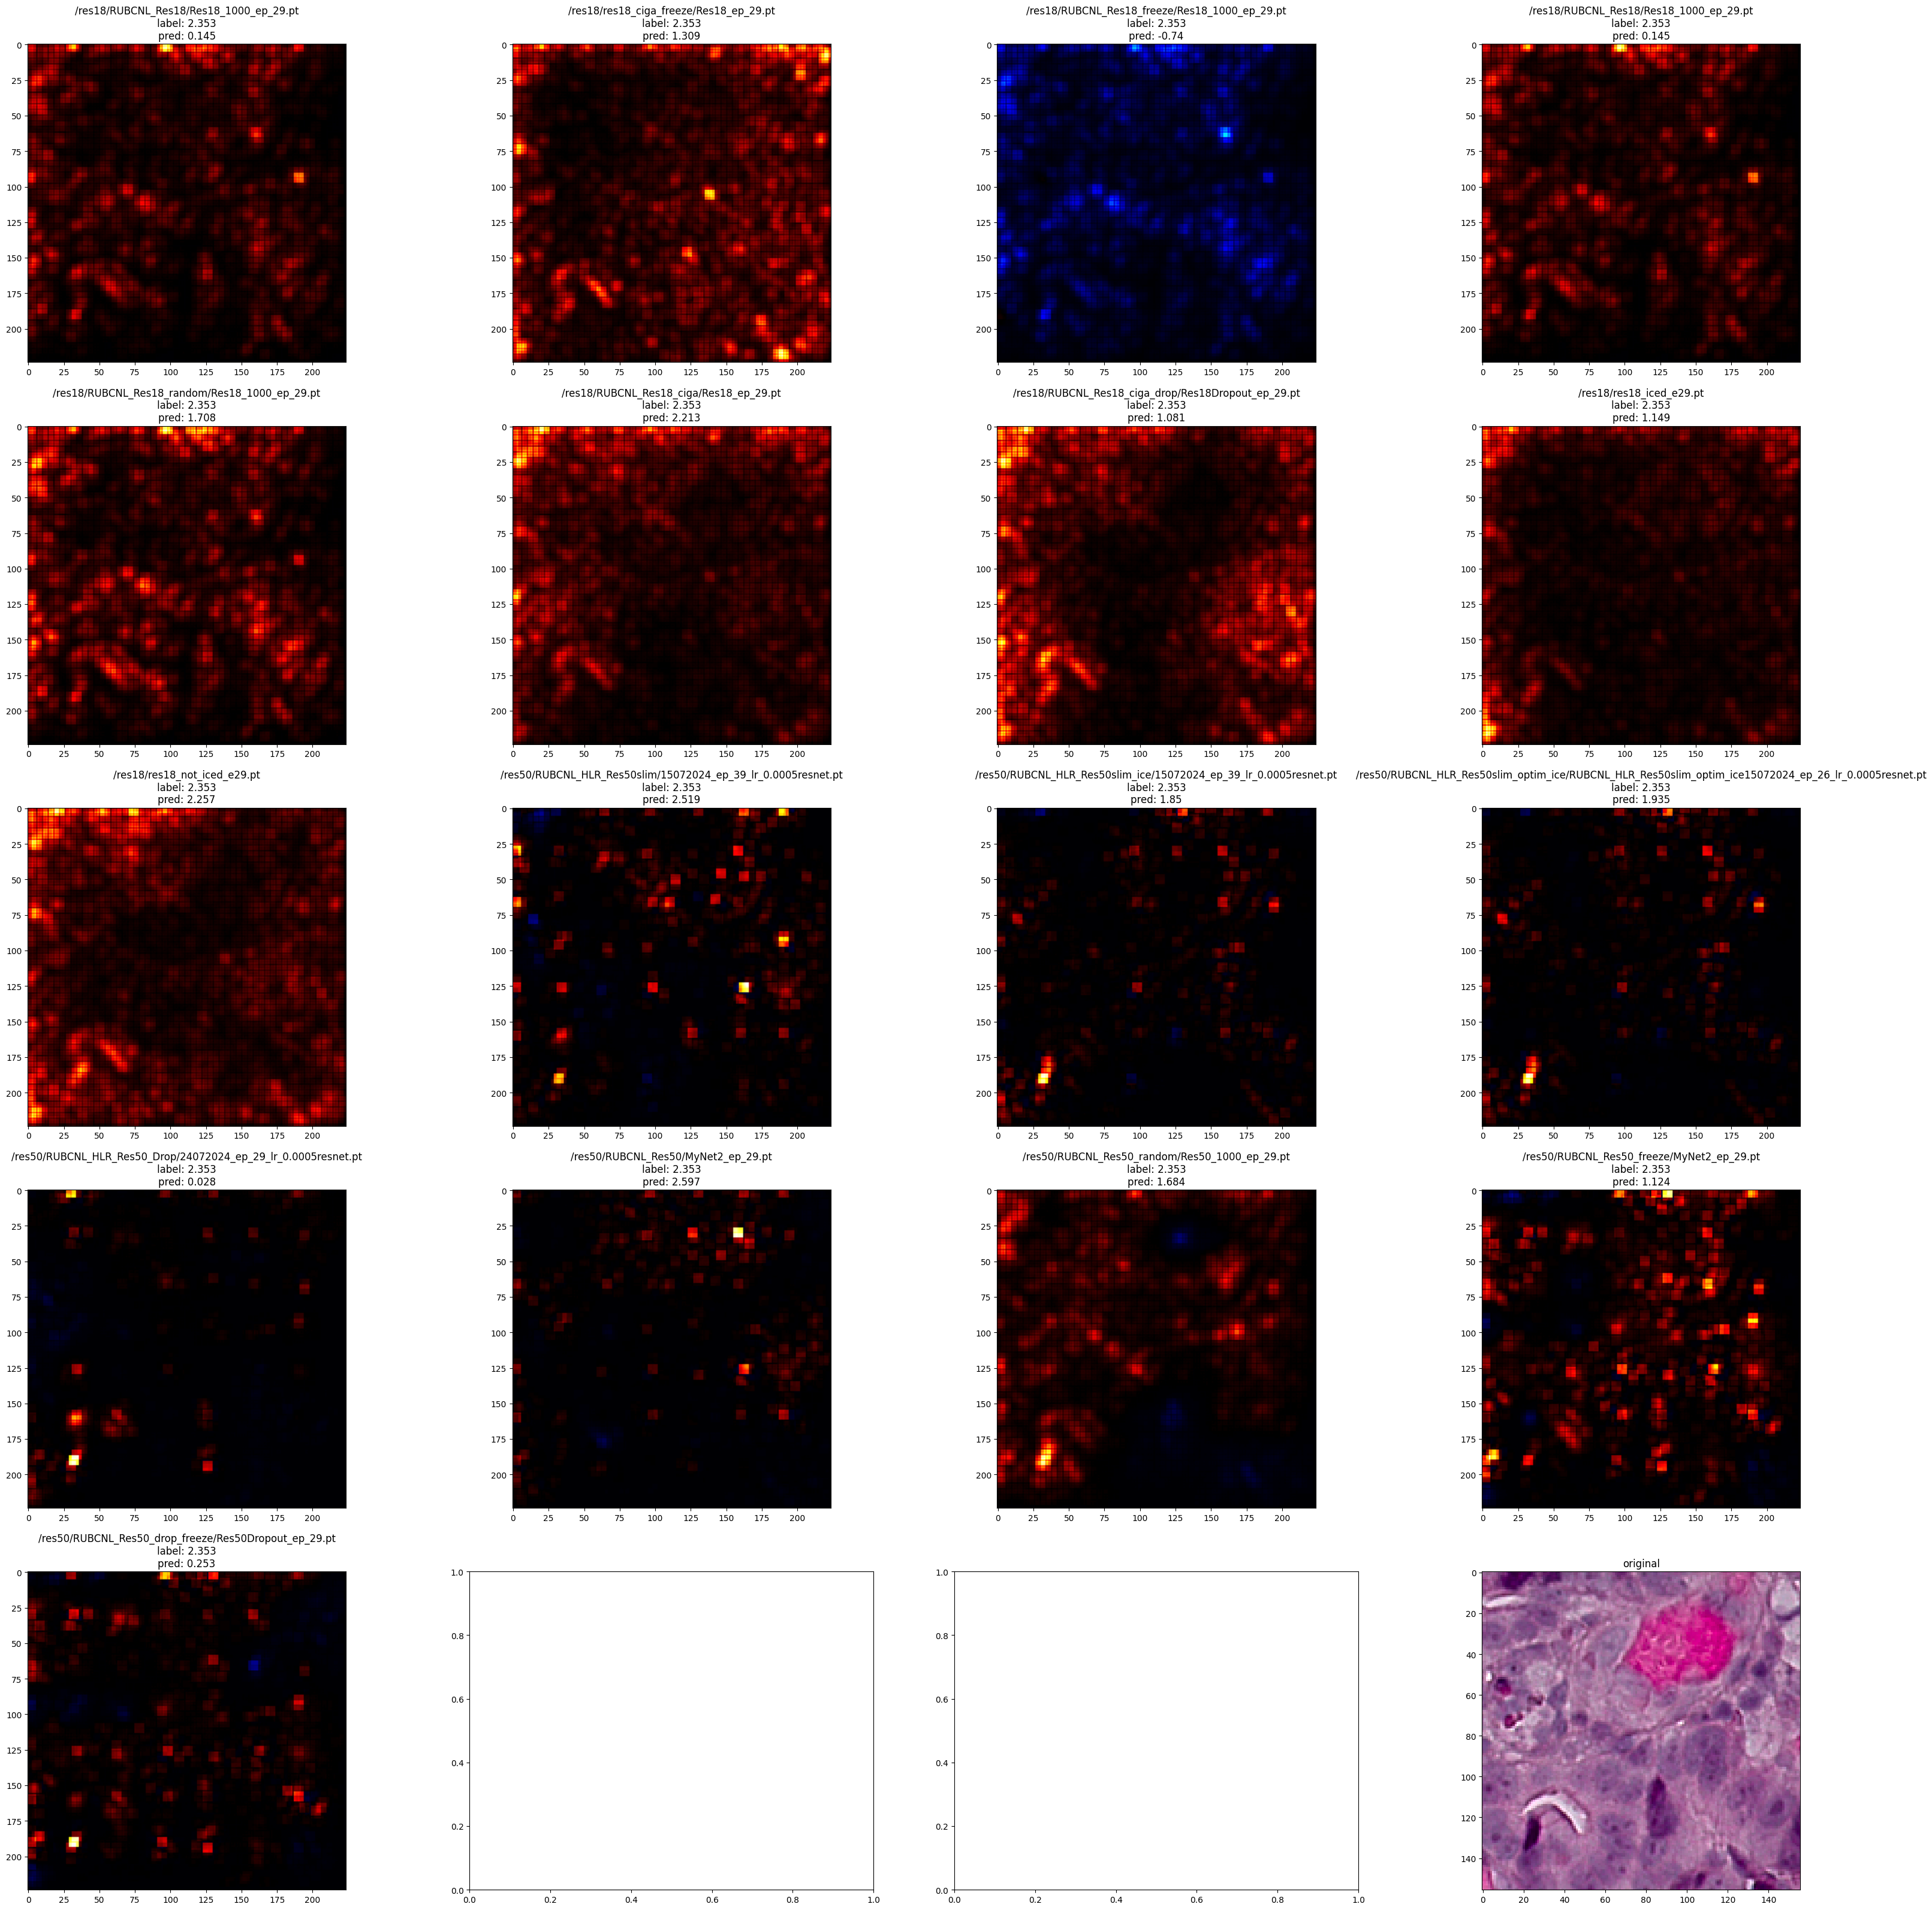

In [64]:
def plot_model_comparison(grads_res, grads_vgg, image_path, width=4, subplot_size=40):
    plt.figure(figsize=(1000,1000))
    height = int((len(grads_res) + len(grads_vgg) + 1) / width + 0.999)
    f, ax = plt.subplots(height,width)
    f.set_figheight(subplot_size)
    f.set_figwidth(subplot_size)
    for i in range(len(grads_res)):
        ax[int(i/width),i%width].imshow(grads_res[i][0])
        ax[int(i/width),i%width].set_title(grads_res[i][1]+"\nlabel: "+str(round(grads_res[i][2], 3))+"\npred: "+str(round(grads_res[i][3], 3)))

    for i in range(len(grads_res), len(grads_vgg)):
        ax[int(i/width),i%width].imshow(grads_vgg[i][0])
        ax[int(i/width),i%width].set_title(grads_vgg[i][1]+"\nlabel: "+str(round(grads_vgg[i][2], 3))+"\npred: "+str(round(grads_vgg[i][3], 3)))
    img = Image.open(image_path)
    ax[-1,-1].imshow(img)
    ax[-1,-1].set_title('original')
    plt.show()
    
    
best = [small_vals[0:5], middle_vals[0:5], big_vals[0:5]]
worst = [small_vals[-5:], middle_vals[-5:], big_vals[-5:]]
# interesting:
interesting = []
interesting.append(best[0].index.values[1])
#set = worst[2]
#id = set.index.values[1]


set = best[2]
id = set.index.values[1]
row = df.iloc[id]
print(id)
grads_res = get_grads(resnets, composite_res, id, df, loader)
grads_vgg = get_grads(vggs, composite_vgg, id, df, loader)
print(len(grads_res))
print(len(grads_vgg))
plot_model_comparison(grads_res, [], row.path)

In [44]:
# pearson
target = df["RUBCNL"]
preds = df.iloc[:, 5:]
print(preds.columns)

Index(['../models/res18/RUBCNL_Res18/Res18_1000_ep_29.pt',
       '../models/res18/res18_ciga_freeze/Res18_ep_29.pt',
       '../models/res18/RUBCNL_Res18_freeze/Res18_1000_ep_29.pt',
       '../models/res18/RUBCNL_Res18_random/Res18_1000_ep_29.pt',
       '../models/res18/RUBCNL_Res18_ciga/Res18_ep_29.pt',
       '../models/res18/RUBCNL_Res18_ciga_drop/Res18Dropout_ep_29.pt',
       '../models/res18/res18_iced_e29.pt',
       '../models/res18/res18_not_iced_e29.pt',
       '../models/res50/RUBCNL_HLR_Res50slim/15072024_ep_39_lr_0.0005resnet.pt',
       '../models/res50/RUBCNL_HLR_Res50slim_ice/15072024_ep_39_lr_0.0005resnet.pt',
       '../models/res50/RUBCNL_HLR_Res50slim_optim_ice/RUBCNL_HLR_Res50slim_optim_ice15072024_ep_26_lr_0.0005resnet.pt',
       '../models/res50/RUBCNL_HLR_Res50_Drop/24072024_ep_29_lr_0.0005resnet.pt',
       '../remote_models/res50/RUBCNL_Res50/MyNet2_ep_29.pt',
       '../models/res50/RUBCNL_Res50_random/Res50_1000_ep_29.pt',
       '../models/res50/RUBCNL_

In [54]:
pearsons = pd.DataFrame(columns=preds.columns)
print(patients)
for i in range(len(filenames)):
    df_tmp = pd.read_csv(filenames[i])
    target = df_tmp["RUBCNL"]
    preds = df_tmp.iloc[:, 5:]
    row = []
    for name, data in preds.items():
        pearsons.at[i,name] = round(stats.pearsonr(target, data)[0],3)
    print(pearsons.shape)
#print(pearsons.head())
print(pearsons.shape)
pearsons['idx'] = patients
pearsons.set_index('idx', append=True)
pearsons.head()
    

['p020', 'p016', 'p026', 'p014', 'p013', 'p025', 'p007', 'p009', 'p008']
(1, 19)
(2, 19)
(3, 19)
(4, 19)
(5, 19)
(6, 19)
(7, 19)
(8, 19)
(9, 19)
(9, 19)


,../models/res18/RUBCNL_Res18/Res18_1000_ep_29.pt,../models/res18/res18_ciga_freeze/Res18_ep_29.pt,../models/res18/RUBCNL_Res18_freeze/Res18_1000_ep_29.pt,../models/res18/RUBCNL_Res18_random/Res18_1000_ep_29.pt,../models/res18/RUBCNL_Res18_ciga/Res18_ep_29.pt,../models/res18/RUBCNL_Res18_ciga_drop/Res18Dropout_ep_29.pt,../models/res18/res18_iced_e29.pt,../models/res18/res18_not_iced_e29.pt,../models/res50/RUBCNL_HLR_Res50slim/15072024_ep_39_lr_0.0005resnet.pt,../models/res50/RUBCNL_HLR_Res50slim_ice/15072024_ep_39_lr_0.0005resnet.pt,../models/res50/RUBCNL_HLR_Res50slim_optim_ice/RUBCNL_HLR_Res50slim_optim_ice15072024_ep_26_lr_0.0005resnet.pt,../models/res50/RUBCNL_HLR_Res50_Drop/24072024_ep_29_lr_0.0005resnet.pt,../remote_models/res50/RUBCNL_Res50/MyNet2_ep_29.pt,../models/res50/RUBCNL_Res50_random/Res50_1000_ep_29.pt,../models/res50/RUBCNL_Res50_freeze/MyNet2_ep_29.pt,../models/res50/RUBCNL_Res50_drop_freeze/Res50Dropout_ep_29.pt,../models/vgg13/dropout/VGG13_Dropout_ep_29.pt,../models/vgg13/base_model/VGG13_ep_29.pt,../models/vgg13/random_weights/VGG13_ep_29.pt,idx
0,0.515,0.666,-0.584,0.685,0.932,0.819,0.725,0.938,0.996,0.674,0.67,0.199,0.995,0.835,0.707,0.632,0.568,0.207,0.243,p020
1,0.738,0.799,-0.791,0.851,0.964,0.909,0.848,0.963,0.997,0.814,0.812,0.392,0.996,0.883,0.812,0.766,0.692,0.178,0.105,p016
2,0.438,0.602,-0.379,0.607,0.552,0.591,0.616,0.575,0.619,0.576,0.579,0.387,0.588,0.579,0.56,0.602,0.613,0.135,0.037,p026
3,0.546,0.652,-0.569,0.722,0.957,0.839,0.733,0.951,0.997,0.671,0.664,0.341,0.995,0.87,0.693,0.614,0.523,0.18,0.059,p014
4,0.427,0.694,-0.658,0.752,0.944,0.849,0.593,0.592,0.658,0.566,0.567,0.323,0.994,0.86,0.753,0.669,0.594,0.054,-0.011,p013
